In [79]:
##import modules

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [80]:
##Load the data set
df=pd.read_csv("AirPassengers.csv")
df.set_index('Month',inplace=True)
df.head()

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


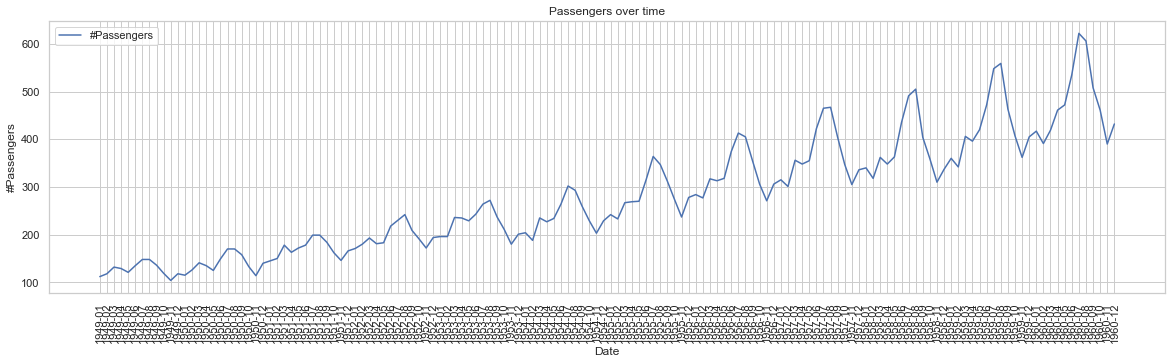

In [81]:
## Explotary data analysis
plt.figure(figsize=(20,5))
plt.plot(df.index,df['#Passengers'],label='#Passengers')
plt.xlabel('Date')
plt.ylabel('#Passengers')
plt.title("Passengers over time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

In [82]:
## perform seasonal decompose

result=seasonal_decompose(df['#Passengers'],model='multiplicative',period=12)



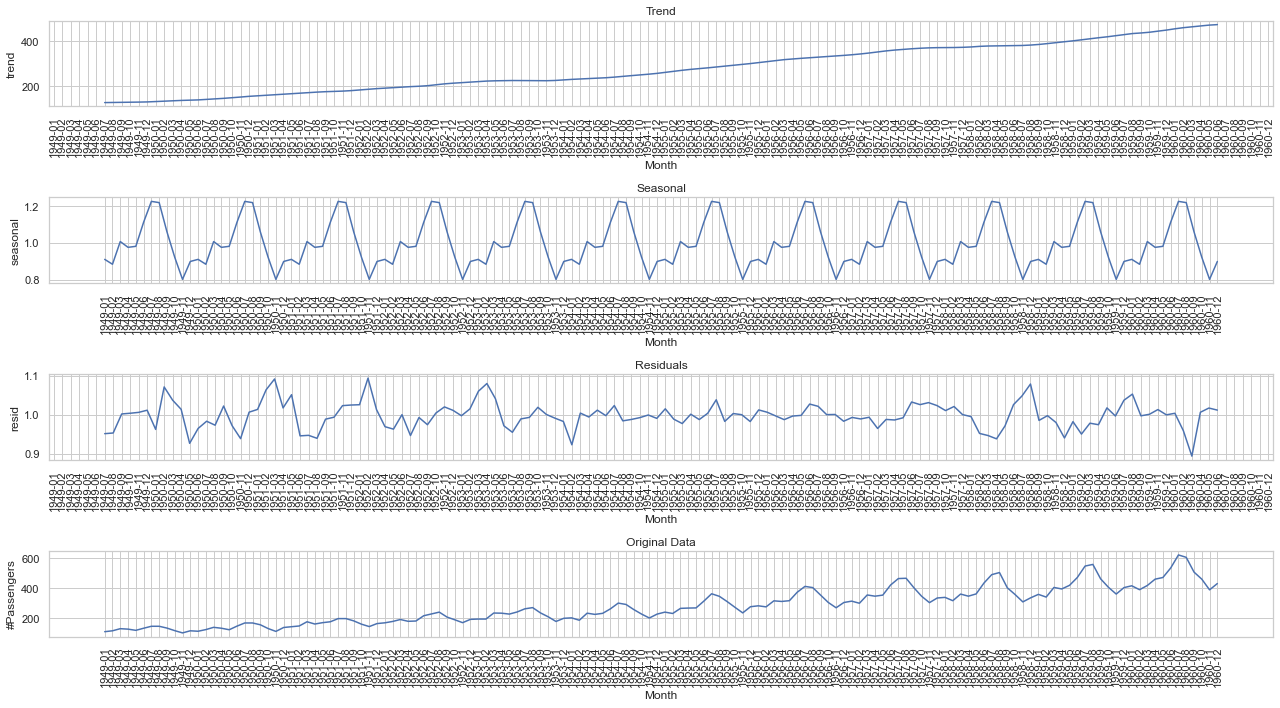

In [83]:
## Lets plot the values in the plot
sns.set(style='whitegrid')
plt.figure(figsize=(18,10))

# trend component
plt.subplot(411)
sns.lineplot(data=result.trend)
plt.title('Trend')
plt.xticks(rotation=90)



# seasonal component
plt.subplot(412)
sns.lineplot(data=result.seasonal)
plt.title('Seasonal')
plt.xticks(rotation=90)

# residual component
plt.subplot(413)
sns.lineplot(data=result.resid)
plt.title('Residuals')
plt.xticks(rotation=90)

# original data component
plt.subplot(414)
sns.lineplot(data=df['#Passengers'])
plt.title('Original Data')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()



In [84]:
seasonal_period=12

In [85]:
from statsmodels.tsa.stattools import adfuller #Augmented dickey_fuller test

result=adfuller(df['#Passengers'],autolag='AIC') # akakie information criterion

print('ADF static :',result[0])
print('p_Value :',result[1])

ADF static : 0.8153688792060543
p_Value : 0.9918802434376411


In [86]:
#first order differencing

result=adfuller(df['#Passengers'].diff().dropna(),autolag='AIC')

print('ADF static :',result[0])
print('p_Value :',result[1])

ADF static : -2.8292668241700034
p_Value : 0.054213290283824954


In [87]:
#second order differencing

result=adfuller(df['#Passengers'].diff().diff().dropna(),autolag='AIC')

print('ADF static :',result[0])
print('p_Value :',result[1])

ADF static : -16.384231542468488
p_Value : 2.7328918500143186e-29


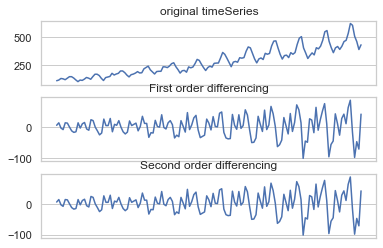

In [88]:
#plot the differencing values
fig,(ax1,ax2,ax3)=plt.subplots(3)

ax1.plot(df)
ax1.set_title('original timeSeries')
ax1.axes.xaxis.set_visible(False)

ax2.plot(df.diff())
ax2.set_title('First order differencing')
ax2.axes.xaxis.set_visible(False)

ax3.plot(df.diff())
ax3.set_title('Second order differencing')
ax3.axes.xaxis.set_visible(False)

plt.show()



In [89]:
# the time series becomes stationary after first order differencing


## Define parameters for ARIMA


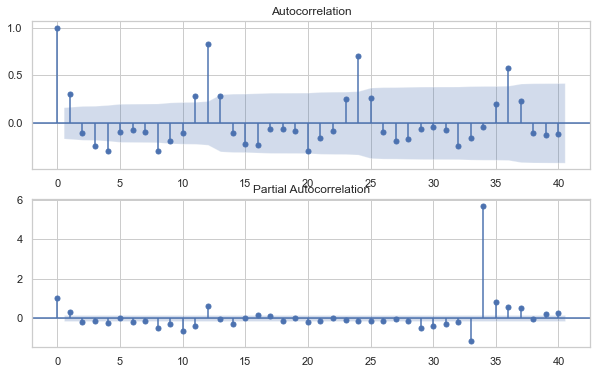

In [90]:
fig,ax=plt.subplots(2,1,figsize=(10,6))
sm.graphics.tsa.plot_acf(df.diff().dropna(),lags=40,ax=ax[0])
sm.graphics.tsa.plot_pacf(df.diff().dropna(),lags=40,ax=ax[1])

plt.show()

In [91]:
p=2 #pacf
d=1 #first order differencing
q=1 #acf

In [92]:
P=1
D=0
Q=3

# Model Training

In [93]:
#define arima model

from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(df['#Passengers'],order=(p,d,q),seasonal_order=(P,D,Q,seasonal_period))
fitted_model=model.fit()
print(fitted_model.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                #Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2, 3], 12)   Log Likelihood                -563.224
Date:                                    Tue, 16 Jul 2024   AIC                           1142.448
Time:                                            21:10:50   BIC                           1166.151
Sample:                                        01-01-1949   HQIC                          1152.080
                                             - 12-01-1960                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6247      0.101      6.170      0

## Forecasting

In [94]:
# forecasting for next 1 year
forecast_steps=12
forecast=fitted_model.get_forecast(steps=forecast_steps)

# create the date range for the forcasted values

forecast_index=pd.date_range(start=df.index[-1],periods=forecast_steps+1,freq='M')[1:].strftime('%y-%m') #to remove start date

In [95]:
#creating a forecast data frame

forecast_df=pd.DataFrame({
    "Forecast": list(forecast.predicted_mean),
    "Lower CI" : list(forecast.conf_int().iloc[:,0]),
    "Upper CI" : list(forecast.conf_int().iloc[:,1])
},index=forecast_index)

forecast_df.head()

,Forecast,Lower CI,Upper CI
61-01,446.728100,424.884543,468.571658
61-02,423.354426,397.217069,449.491782
61-03,456.481789,426.865902,486.097676
61-04,491.603950,459.573112,523.634787
61-05,505.178033,471.297766,539.058300


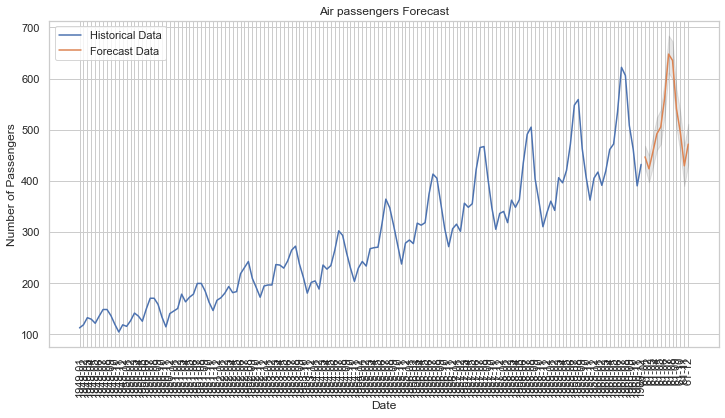

In [96]:
#plot the forecast values

plt.figure(figsize=(12,6))
plt.plot(df['#Passengers'],label='Historical Data')
plt.plot(forecast_df['Forecast'],label='Forecast Data')
plt.fill_between(forecast_df.index,forecast_df['Lower CI'],forecast_df['Upper CI'],color='k',alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.title('Air passengers Forecast')
plt.xticks(rotation=90)
plt.legend()
plt.show()